In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow loading of truncated images

class PeopleCountDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_file = self.data.iloc[idx]['image_file_name']
        label = self.data.iloc[idx]['count']
        image_path = os.path.join(self.image_folder, image_file)
        
        try:
            image = Image.open(image_path).convert('RGB')
        except OSError:
            print(f"Error loading image: {image_path}, skipping...")
            return None  # Return None for invalid data
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float)

In [12]:
# 2. VGG-16 Model
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1)  # Outputting head count as a single value
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [13]:
# 3. Training Function
def train_model(model, dataloader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")

In [81]:
# Paths
csv_file = '/kaggle/input/classroom-data/Classroom-Data/images13.9/labels.csv'
image_folder = '/kaggle/input/classroom-data/Classroom-Data/images13.9/images'

In [82]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [83]:
from torch.utils.data import DataLoader

# Custom collate function to skip None samples
def collate_fn(batch):
    batch = [sample for sample in batch if sample is not None]
    return torch.utils.data.default_collate(batch)

# Dataset and DataLoader
dataset = PeopleCountDataset(csv_file, image_folder, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [58]:
# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG16().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [84]:
# Train the model
train_model(model, dataloader, criterion, optimizer, device, epochs=30)

Epoch [1/30], Loss: 86.6806
Epoch [2/30], Loss: 44.0981
Epoch [3/30], Loss: 45.5252
Epoch [4/30], Loss: 50.4276
Epoch [5/30], Loss: 39.5746
Epoch [6/30], Loss: 65.3329
Epoch [7/30], Loss: 55.6360
Epoch [8/30], Loss: 55.1104
Epoch [9/30], Loss: 58.4987
Epoch [10/30], Loss: 37.2574
Epoch [11/30], Loss: 35.2501
Epoch [12/30], Loss: 48.1771
Epoch [13/30], Loss: 36.0210
Epoch [14/30], Loss: 22.9442
Epoch [15/30], Loss: 15.5513
Epoch [16/30], Loss: 17.2146
Epoch [17/30], Loss: 17.5901
Epoch [18/30], Loss: 11.2789
Epoch [19/30], Loss: 13.8242
Epoch [20/30], Loss: 17.9051
Epoch [21/30], Loss: 13.6868
Epoch [22/30], Loss: 14.4740
Epoch [23/30], Loss: 8.7882
Epoch [24/30], Loss: 8.6726
Epoch [25/30], Loss: 14.6126
Epoch [26/30], Loss: 11.8688
Epoch [27/30], Loss: 12.8232
Epoch [28/30], Loss: 11.6053
Epoch [29/30], Loss: 12.6794
Epoch [30/30], Loss: 10.7829


In [85]:
# Save the model
torch.save(model.state_dict(), 'vgg16_headcount.pth')

In [ ]:
import matplotlib.pyplot as plt
img_path = "/kaggle/input/classroom-data/Classroom-Data/images13.9/images/img546.jpg"
img = Image.open(img_path).convert('RGB')
img = img.resize((224, 224))
plt.imshow(img)
plt.show()

In [87]:
input_tensor = transform(img)
input_tensor = input_tensor.unsqueeze(0)

In [88]:
# Move to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)

In [89]:
# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(input_tensor)

In [90]:
# Output: Predicted headcount
predicted_count = output.item()  # Convert tensor to a Python number
print(f"Predicted Headcount: {predicted_count}")

Predicted Headcount: 55.46255874633789


**Grad-CAM (Gradient-weighted Class Activation Mapping)**

In [91]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [92]:
def preprocess_image(img_path):
    # Preprocessing steps (resize, tensor conversion, normalization)
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    input_tensor = preprocess(img).unsqueeze(0)
    return input_tensor, img

def grad_cam(model, input_tensor, target_layer_name, device):
    # Hook for gradients
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    
    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks on the target layer
    target_layer = dict(model.named_modules())[target_layer_name]
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    # Forward pass
    input_tensor = input_tensor.to(device)
    model.eval()
    output = model(input_tensor)
    output.backward()  # Backpropagate to compute gradients

    # Get gradients and activations
    gradients = gradients[0].cpu().data.numpy()
    activations = activations[0].cpu().data.numpy()

    # Compute Grad-CAM
    weights = np.mean(gradients, axis=(2, 3))  # Global average pooling of gradients
    cam = np.zeros(activations.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights[0]):
        cam += w * activations[0, i, :, :]
    cam = np.maximum(cam, 0)  # ReLU
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]

    return cam

In [93]:
# Load your trained model
model_path = "/kaggle/working/vgg16_headcount.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)

/tmp/ipykernel_23/2443073437.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [94]:
# Path to the image for visualization
img_path = "/kaggle/input/test-imageimg265/img265.jpg"
input_tensor, original_image = preprocess_image(img_path)

In [95]:
# Generate Grad-CAM
target_layer_name = "features.29"  # Example: Last convolutional layer of VGG-16
cam = grad_cam(model, input_tensor, target_layer_name, device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [96]:
# Overlay Grad-CAM on the original image
original_image = original_image.resize((224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.array(heatmap) / 255.0
superimposed_img = 0.5 * heatmap + np.array(original_image) / 255.0

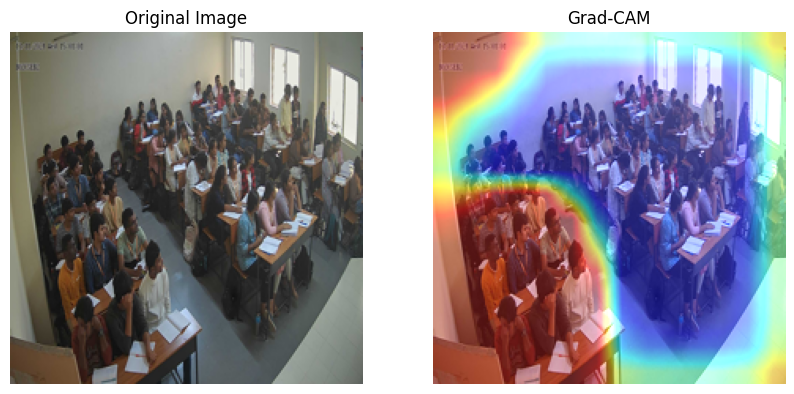

In [97]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()

## Saliency Maps and Feature Maps, refer my github uid: harinivas-28